# 03. Convolutional Neural Networks and Computer Vision with TensorFlow

So far, we have covered the basics of TensorFlow and built a handful of models to work across different problems.

Now we're going to get specific and see how a special kind of network, convolutional neural networks (CNNs), can be used for computer vision (detecting patters in visual data).

> 🔑 **Note:** In depp learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some of these architectures generally work better than others.

For example, you might want to:

* Classify whether a picture of food contains pizza or steak (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)

In this notebook, we're going to follow the TensorFlow modeling workflow we've been following so far whilst learning about how to build and use CNNs.

### Get the Data

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes.

In [1]:
import zipfile

# Download zip file of pizza_steak images
!curl -O -s https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
    
# Unzip the download file
zip_ref = zipfile.ZipFile('pizza_steak.zip', 'r')
zip_ref.extractall()
zip_ref.close()

### Inspect the Data

In [2]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "pizza_steak".
There are 2 directories and 0 images in "pizza_steak/train".
There are 0 directories and 750 images in "pizza_steak/train/steak".
There are 0 directories and 750 images in "pizza_steak/train/pizza".
There are 2 directories and 0 images in "pizza_steak/test".
There are 0 directories and 250 images in "pizza_steak/test/steak".
There are 0 directories and 250 images in "pizza_steak/test/pizza".


In [3]:
# Get the class names (programmatically, this is very helpful with longer class lists)
import pathlib
import numpy as np

data_dir = pathlib.Path('pizza_steak/train/')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


> 🔑 **Note:** Whenever you are working with data, it's always a good idea to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. **Vizualize, vizualize, vizualize.**

In [4]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup target directory
    target_folder = target_dir + target_class
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    
    print(f'Image Shape: {img.shape}')
    
    return img

Image Shape: (512, 512, 3)


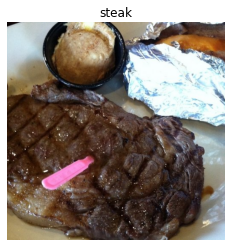

In [5]:
img = view_random_image(target_dir='pizza_steak/train/',
                        target_class='steak')

### Typical Architecture of a Convolutional Neural Network

| Hyperparameter/Layer Type | Function | Typical Values |
|:--------------------------|:---------|:---------------|
| Input Image(s)            | Target images you'd like to find patterns in | Whatever you can take a photo (or video) of |
| Input Layer | Takes in the target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution Layer | Extracts/learns the most important features from the target image(s) | Multiple, can create with `tf.keras.layers.ConvXD` (X can be multiple values) |
| Hidden Activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU (`tf.keras.activations.relu`) |
| Pooling Layer | Reduceds the dimensionality of learned image features | Average (`tf.keras.layers.AvgPool2D`) or Max (`tf.keras.layers.MaxPool2D`) |
| Fully Connected Layer | Further refines learned features from convolution layers | `tf.keras.layers.Dense` |
| Output Layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak, or sushi) |
| Output Activation | Adds non-linearity to output layer | `tf.keras.activations.sigmoid` (binary classification) or `tf.keras.activations.softmax` |

> 🔑 **Note:** A **baseline** is a score or evaluation metric you want to try and beat. Usually you'll start with a simple model, create a baseline and try to beat it by increasing complexity of the model. A really fun way to learn machine learning is to find some kind of modeling paper with a published result and try to beat it.

> 📖 **Resource:** The architecture we're using below is a scaled down version of [VGG-16](https://arxiv.org/abs/1505.06798), a convolutional neural network which came 2nd in the 2014 [ImageNet classification competition](https://image-net.org/).

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)

# Setup the train and test directories
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               seed=42)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# 1. Create a model

model_1 = Sequential([
    Conv2D(filters=10,
           kernel_size=3, # Can also be (3, 3)
           activation='relu',
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2, # Can also be (2, 2)
              padding='valid'), # Can also be 'same'
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(1, activation='sigmoid') # Binary activation output
])

# 2. Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

2022-05-31 15:53:07.380128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 15:53:07.380151: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


2022-05-31 15:53:10.454239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 15:53:10.454622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 15:53:10.454704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-31 15:53:10.454772: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-31 15:53:10.454837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/5
47/47 [==============================] - 41s 856ms/step - loss: 0.6083 - accuracy: 0.6653 - val_loss: 0.4467 - val_accuracy: 0.7880
Epoch 2/5
47/47 [==============================] - 35s 742ms/step - loss: 0.4406 - accuracy: 0.7973 - val_loss: 0.3444 - val_accuracy: 0.8600
Epoch 3/5
47/47 [==============================] - 35s 747ms/step - loss: 0.4009 - accuracy: 0.8313 - val_loss: 0.3218 - val_accuracy: 0.8740
Epoch 4/5
47/47 [==============================] - 41s 878ms/step - loss: 0.3492 - accuracy: 0.8527 - val_loss: 0.3284 - val_accuracy: 0.8760
Epoch 5/5
47/47 [==============================] - 41s 882ms/step - loss: 0.3133 - accuracy: 0.8707 - val_loss: 0.3023 - val_accuracy: 0.8740


In [7]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

### Using a Previous Model

In [8]:
# Set random seed
tf.random.set_seed(42)

# 1. Create a model
model_2 = Sequential([
    Flatten(input_shape=(224, 224, 3)), # Dense layers expect a 1-dimensional vector as input
    Dense(4, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 2. Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 5s 109ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 5s 103ms/step - loss: 0.6932 - accuracy: 0.4827 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 5s 107ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 105ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 104ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [9]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


> 🔑 Note: You can think of trainable parameters as patterns a model can learn from data. Intuitiely, you might think more is better. And in some cases it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, a convolutional neural network seeks to sort out and learn the most important patterns in an image. So even though there are less learnable parameters in our convolutional neural network, these are often more helpful in decphering between different features in an image.

> 🔑 Note: Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the complexity of your model.

In [10]:
# Set random seed
tf.random.set_seed(42)

# 1. Create a model
model_3 = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(100, activation='relu'), # More neurons
    Dense(100, activation='relu'),
    Dense(100, activation='relu'), # Add a layer
    Dense(1, activation='sigmoid')
])

# 2. Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 10s 202ms/step - loss: 3.5368 - accuracy: 0.6247 - val_loss: 3.4908 - val_accuracy: 0.5440
Epoch 2/5
47/47 [==============================] - 9s 201ms/step - loss: 1.3917 - accuracy: 0.6767 - val_loss: 2.6696 - val_accuracy: 0.5300
Epoch 3/5
47/47 [==============================] - 9s 201ms/step - loss: 1.2452 - accuracy: 0.7273 - val_loss: 0.7284 - val_accuracy: 0.7300
Epoch 4/5
47/47 [==============================] - 9s 201ms/step - loss: 0.5761 - accuracy: 0.7693 - val_loss: 0.4881 - val_accuracy: 0.7760
Epoch 5/5
47/47 [==============================] - 9s 199ms/step - loss: 0.5667 - accuracy: 0.7807 - val_loss: 0.7424 - val_accuracy: 0.6840


In [11]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Even though this model has close to 500x (~15,000,000 vs ~31,000) more trainable parameters, `model_3` still doesn't outperform `model_1`.

### Binary Classification: Let's Break It Down

Whatever kind of data you're dealing with, it's a good idea to visualize at least 10-100 samples to start to building your own mental model of the data.

In our case, we might notice that the steak images tend to have darker colours where as pizza images tend to have a distinct circular shape in the middle. These might be patterns that our neural network picks up on.

You an also notice if some of your data is messed up (for example, has the wrong label) and start to consider ways you might go about fixing it.

> 📖 **Resource:** To see how this data was processed into the file format we're using, see the [preprocessing handbook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

In [12]:
# Uncomment to re-import data if necessary
# import zipfile

# # Download zip file of pizza_steak images
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

Image Shape: (382, 512, 3)
Image Shape: (512, 512, 3)


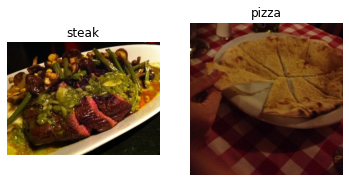

In [13]:
# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image('pizza_steak/train/', 'steak')
plt.subplot(1, 2, 2)
pizza_image = view_random_image('pizza_steak/train/', 'pizza')

### Preprocessing (Prepare for Model)

In [14]:
# Define train and test directory paths
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'



Our next step is to turn our data into batches.

A batch is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:

* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32?

A [batch size of 32 is good for your health](https://twitter.com/ylecun/status/989610208497360896?s=20).

No seriously, there are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

To turn our data into batches, we'll first create an instance of `ImageDataGenerator` for each of our datasets.


In [15]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

> 🔑 **Note:** For more transformation options such as data augmentation (we'll see this later), refer to the [`ImageDataGenerator` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [16]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.




Wonderful! Looks like our training dataset has 1500 images belonging to 2 classes (pizza and steak) and our test dataset has 500 images also belonging to 2 classes.

Some things to here:

* Due to how our directories are structured, the classes get inferred by the subdirectory names in train_dir and test_dir.
* The target_size parameter defines the input size of our images in (height, width) format.
* The class_mode value of 'binary' defines our classification problem type. If we had more than two classes, we would use 'categorical'.
* The batch_size defines how many images will be in each batch, we've used 32 which is the same as the default.

In [17]:
# Get a sample of the training data batch
images, labels = train_data.next() # Get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [18]:
# Look at image and label data
images[0], images[0].shape, labels

(array([[[0.47058827, 0.40784317, 0.34509805],
         [0.48627454, 0.42352945, 0.36078432],
         [0.48627454, 0.43529415, 0.37254903],
         ...,
         [0.82745105, 0.7137255 , 0.48627454],
         [0.8431373 , 0.7372549 , 0.5294118 ],
         [0.87843144, 0.77647066, 0.58431375]],
 
        [[0.50980395, 0.427451  , 0.36078432],
         [0.5058824 , 0.42352945, 0.35686275],
         [0.5137255 , 0.4431373 , 0.3647059 ],
         ...,
         [0.82745105, 0.7058824 , 0.48235297],
         [0.82745105, 0.70980394, 0.49803925],
         [0.8431373 , 0.73333335, 0.5372549 ]],
 
        [[0.5254902 , 0.427451  , 0.34901962],
         [0.5372549 , 0.43921572, 0.36078432],
         [0.5372549 , 0.45098042, 0.36078432],
         ...,
         [0.82745105, 0.7019608 , 0.4784314 ],
         [0.82745105, 0.7058824 , 0.4901961 ],
         [0.8352942 , 0.7176471 , 0.5137255 ]],
 
        ...,
 
        [[0.77647066, 0.5647059 , 0.2901961 ],
         [0.77647066, 0.53333336, 0.23137

Due to our rescale parameter, the images are now in (224, 224, 3) shape tensors with values between 0 and 1.

Due to the class_mode parameter being 'binary' our labels are either 0 (pizza) or 1 (steak).

Now that our data is ready, our model is going to try and figure out the patterns between the image tensors and the labels.

In [19]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [20]:
# 1. Create the model
model_4 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])



Great! We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

    Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output

Let's discuss some of the components of the Conv2D layer:

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A **feature** can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these **features** are not defined by us, instead, the model learns them as it applies different filters across the image.

> 📖 **Resources:** For a great demonstration of these in action, be sure to spend some time going through the following:
> * [CNN Explainer Webpage](https://poloclub.github.io/cnn-explainer/) - a great visual overview of many of the concepts we're replicating here with code.
> * [A guide to convolutional arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) - a phenomenal introduction to the math going on behind the scenes of a convolutional neural network.
> * For a great explanation of padding, see this [Stack Overflow answer](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t/39371113#39371113).

Now our model is ready, let's compile it.


In [21]:
# 2. Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

Since we're working on a binary classification problem (pizza vs. steak), the `loss` function we're using is `'binary_crossentropy'`, if it was multi-class, we might use something like `'categorical_crossentropy'`.

Adam with all the default settings is our optimizer and our evaluation metric is accuracy.
4. Fit a model

Our model is compiled, time to fit it.

You'll notice two new parameters here:

* `steps_per_epoch` - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of `train_data` (1500 images in batches of 32 = 1500/32 = ~47 steps)
* `validation_steps` - same as above, except for the `validation_data` parameter (500 test images in batches of 32 = 500/32 = ~16 steps)



In [22]:
len(train_data), len(test_data)

(47, 16)

In [23]:
# 3. Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 59s 1s/step - loss: 1.2669 - accuracy: 0.6133 - val_loss: 0.5431 - val_accuracy: 0.7580
Epoch 2/5
47/47 [==============================] - 61s 1s/step - loss: 0.4613 - accuracy: 0.7953 - val_loss: 0.3930 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 54s 1s/step - loss: 0.3276 - accuracy: 0.8627 - val_loss: 0.3662 - val_accuracy: 0.8380
Epoch 4/5
47/47 [==============================] - 49s 1s/step - loss: 0.1683 - accuracy: 0.9487 - val_loss: 0.4756 - val_accuracy: 0.7740
Epoch 5/5
47/47 [==============================] - 48s 1s/step - loss: 0.0561 - accuracy: 0.9853 - val_loss: 0.5263 - val_accuracy: 0.8040


<AxesSubplot:>

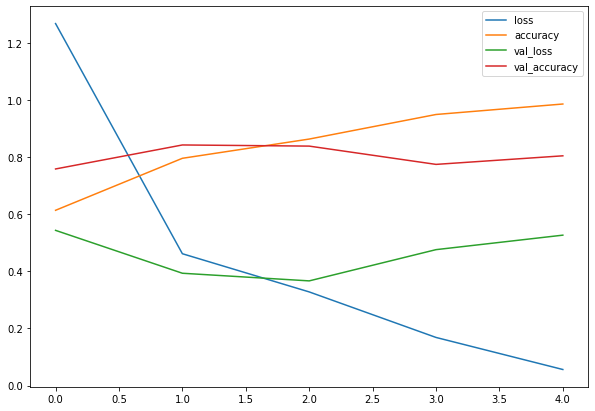

In [24]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7))



Hmm, judging by our loss curves, it looks like our model is overfitting the training dataset.

> 🔑 Note: When a model's validation loss starts to increase, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset too well and thus its ability to generalize to unseen data will be diminished.

To further inspect our model's training performance, let's separate the accuracy and loss curves.


In [25]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel = 'Epochs'
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel = 'Epochs'
    plt.legend()

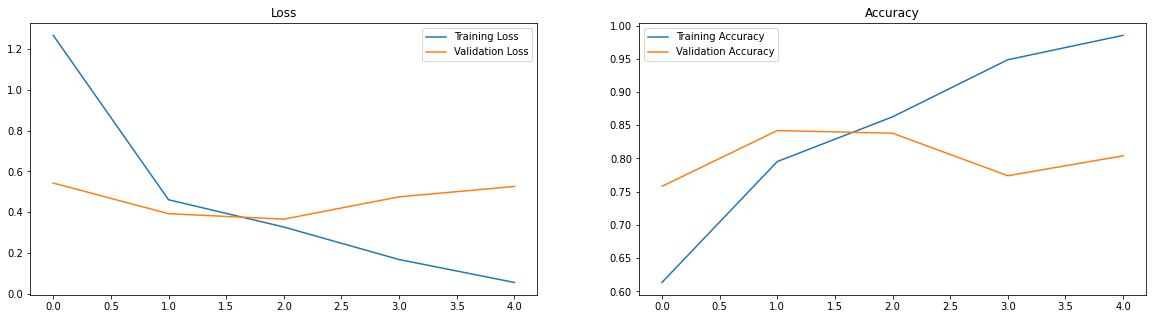

In [26]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

The ideal position for these two curves is to follow each other. If anything, the validation curve should be slightly under the training curve. If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.

In [27]:
# Check out the model architecture 
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### Adjust the Model Parameters

Fitting a machine learning model comes in 3 steps:

1. Create a basline.
2. Beat the baseline by overfitting a larger model.
3. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:

* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

Not really...

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:

* A ConvNet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A ConvNet with max pooling and data augmentation

For the first model, we'll follow the modified basic CNN structure:

    Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output

Let's build it. It'll have the same structure as `model_4` but with a `MaxPool2D()` layer after each convolutional layer.

In [28]:
# 1. Create the model
model_5 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2), # Reduce number of features by half
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

Woah, we've got another layer type we haven't seen before.

If convolutional layers learn the features of an image you can think of a Max Pooling layer as figuring out the most important of those features. We'll see this an example of this in a moment.

In [29]:
# 2. Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 17s 356ms/step - loss: 0.6181 - accuracy: 0.6593 - val_loss: 0.4725 - val_accuracy: 0.7940
Epoch 2/5
47/47 [==============================] - 17s 367ms/step - loss: 0.4776 - accuracy: 0.7827 - val_loss: 0.3956 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 17s 357ms/step - loss: 0.4385 - accuracy: 0.8080 - val_loss: 0.3969 - val_accuracy: 0.8240
Epoch 4/5
47/47 [==============================] - 17s 371ms/step - loss: 0.4468 - accuracy: 0.7960 - val_loss: 0.4002 - val_accuracy: 0.8200
Epoch 5/5
47/47 [==============================] - 17s 372ms/step - loss: 0.4061 - accuracy: 0.8233 - val_loss: 0.3588 - val_accuracy: 0.8640




Okay, it looks like our model with max pooling (`model_5`) is performing worse on the training set but better on the validation set.

Before we checkout its training curves, let's check out its architecture.


In [30]:
# Check out the model architecture
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

Do you notice what's going on here with the output shape in each `MaxPooling2D` layer?

It gets halved each time. This is effectively the `MaxPooling2D` layer taking the outputs of each `Conv2D` layer and saying "I only want the most important features, get rid of the rest".

The bigger the `pool_size` parameter, the more the max pooling layer will squeeze the features out of the image. However, too big and the model might not be able to learn anything.

The results of this pooling are seen in a major reduction of total trainable parameters (8,861 in `model_5` and 477,431 in `model_4`).

Time to check out the loss curves.

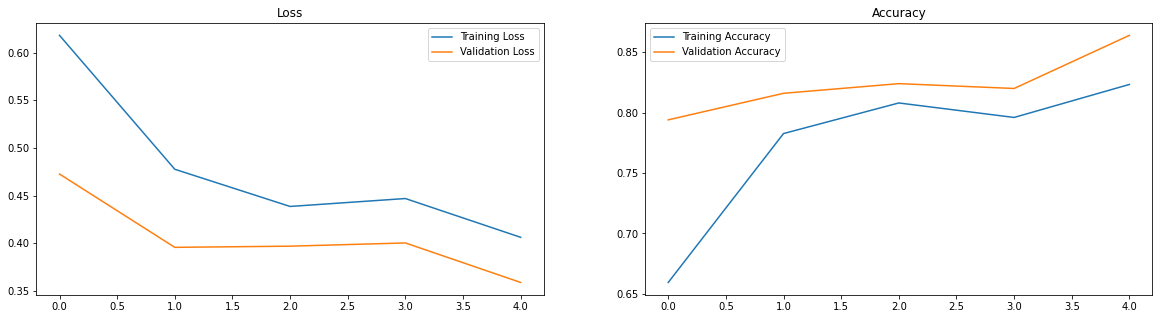

In [31]:
# Plot the loss curves of model_5
plot_loss_curves(history_5)

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

Time to dig into our bag of tricks and try another method of overfitting prevention, data augmentation.

First, we'll see how it's done with code then we'll discuss what it's doing.

To implement data augmentation, we'll have to reinstantiate our [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instances.

In [32]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # Rotate the image between 0 and 20 deg (int, not float)
                                             shear_range=0.2, # Shear the image
                                             zoom_range=0.2, # SZoom into the image
                                             width_shift_range=0.2, # Shift image width-wise
                                             height_shift_range=0.2, # Shift image height-wise
                                             horizontal_flip=True)

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [33]:
# Import data and augment it from training directory
print('Augmented training images:')
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True) # Usually a good idea to shuffle

# Create non-augmented data batches
print('Non-augmented training images:')
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False)

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [34]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augemented_labels = train_data_augmented.next()

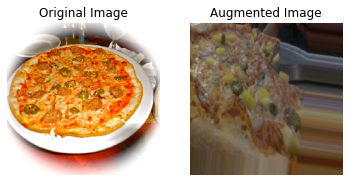

In [35]:
# Show original image and augmented image
random_number = random.randint(0, 32)
plt.subplot(1, 2, 1)
plt.imshow(images[random_number])
plt.title('Original Image')
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(augmented_images[random_number])
plt.title('Augmented Image')
plt.axis(False);

After going through a sample of original and augmented images, you can start to see some of the example transformations on the training images.

Notice how some of the augmented images look like slightly warped versions of the original image. This means our model will be forced to try and learn patterns in less-than-perfect images, which is often the case when using real-world images.

> 🤔 Question: Should I use data augmentation? And how much should I augment?

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the `ImageDataGenerator` class and think about how a model in your use case might benefit from some data augmentation.

Now we've got augmented data, let's try and refit a model on it and see how it affects training.

We'll use the same model as `model_5`.

In [36]:
# 1. Create a model (same as model_5 above)
model_6 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid'),
])

# 2. Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_6 = model_6.fit(train_data_augmented,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 24s 506ms/step - loss: 0.6310 - accuracy: 0.6493 - val_loss: 0.5339 - val_accuracy: 0.7340
Epoch 2/5
47/47 [==============================] - 23s 493ms/step - loss: 0.5304 - accuracy: 0.7493 - val_loss: 0.3774 - val_accuracy: 0.8300
Epoch 3/5
47/47 [==============================] - 24s 501ms/step - loss: 0.4826 - accuracy: 0.7780 - val_loss: 0.3685 - val_accuracy: 0.8300
Epoch 4/5
47/47 [==============================] - 24s 501ms/step - loss: 0.4622 - accuracy: 0.7907 - val_loss: 0.3906 - val_accuracy: 0.8260
Epoch 5/5
47/47 [==============================] - 24s 505ms/step - loss: 0.4698 - accuracy: 0.7747 - val_loss: 0.3802 - val_accuracy: 0.8340


> 🤔 **Question:** Why didn't our model get very good results on the training set to begin with?

It's because when we created `train_data_augmented` we turned off data shuffling using `shuffle=False` which means our model only sees a batch of a single kind of images at a time.

For example, the pizza class gets loaded in first because it's the first class. Thus it's performance is measured on only a single class rather than both classes. The validation data performance improves steadily because it contains shuffled data.

Since we only set `shuffle=False` for demonstration purposes (so we could plot the same augmented and non-augmented image), we can fix this by setting `shuffle=True` on future data generators.

You may have also noticed each epoch taking longer when training with augmented data compared to when training with non-augmented data (~25s per epoch vs. ~10s per epoch).

This is because the `ImageDataGenerator` instance augments the data as it's loaded into the model. The benefit of this is that it leaves the original images unchanged. The downside is that it takes longer to load them in.

> 🔑 **Note:** One possible method to speed up dataset manipulation would be to look into TensorFlow's parrallel reads and buffered prefecting options.



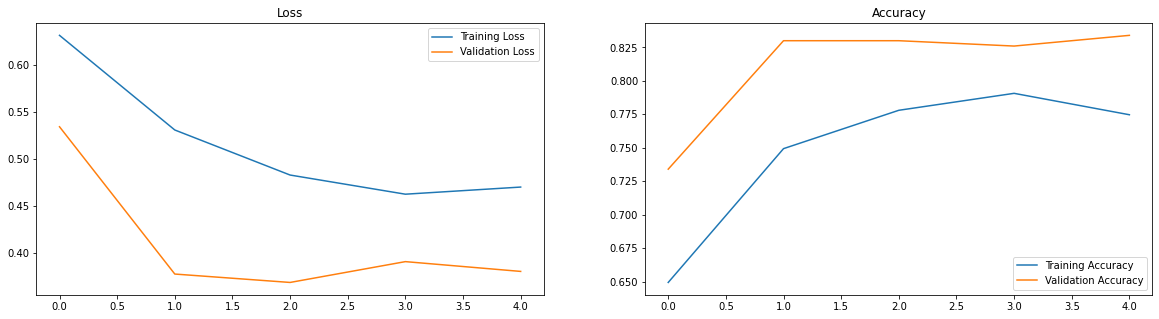

In [37]:
# Check the model's performance history training on augmented data
plot_loss_curves(history_6)

Model improves faster using shuffled data, as the model gets to see examples of both pizza and steak in each batch rather than just one. 

### Repeat Until Satisfied

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as **hyperparameter tuning**.

You can think of hyperparameter tuning as simialr to adjusting the settings on your oven to cook your favourite dish. Although your oven does most of the cooking for you, you can help it by tweaking the dials.

Let's go back to right where we started and try our original model (`model_1` or the TinyVGG architecture from [CNN explainer](https://poloclub.github.io/cnn-explainer/)).

In [38]:
# 1. Create a CNN model (same as Tiny VGG but for binary classification)
model_7 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# 2. Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_7 = model_7.fit(train_data_augmented,
                        epochs=5, 
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 36s 747ms/step - loss: 0.6081 - accuracy: 0.6673 - val_loss: 0.4837 - val_accuracy: 0.7780
Epoch 2/5
47/47 [==============================] - 36s 758ms/step - loss: 0.5590 - accuracy: 0.7213 - val_loss: 0.4176 - val_accuracy: 0.8020
Epoch 3/5
47/47 [==============================] - 36s 763ms/step - loss: 0.4923 - accuracy: 0.7753 - val_loss: 0.3751 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 35s 748ms/step - loss: 0.4983 - accuracy: 0.7647 - val_loss: 0.4320 - val_accuracy: 0.7880
Epoch 5/5
47/47 [==============================] - 36s 757ms/step - loss: 0.4929 - accuracy: 0.7633 - val_loss: 0.3460 - val_accuracy: 0.8460


> 🔑 **Note:** You might've noticed we used some slightly different code to build **model_7** as compared to **model_1**. This is because of the imports we did before, such as from **tensorflow.keras.layers import Conv2D** reduce the amount of code we had to write. Although the code is different, the architectures are the same.

In [39]:
# Check model 1 architecture
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [40]:
# Check model_7 architecture
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_16 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

Now let's check out our Tiny VGG model's performance

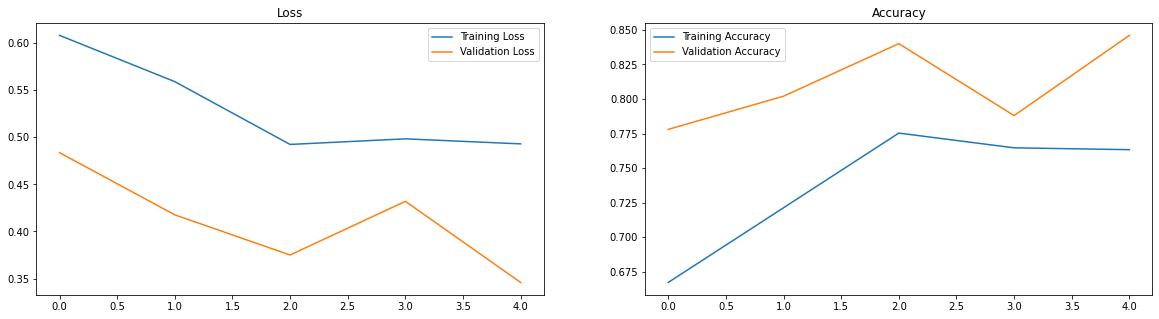

In [41]:
plot_loss_curves(history_7)

It looks like our model didn't perform much better than the original, but that it might improve over more epochs.

In [42]:
# 1. Create the model 
model_8 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# 2. Compile the model
model_8.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Train the model
history_8 = model_8.fit(train_data_augmented,
                        epochs=15,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/15
47/47 [==============================] - 36s 748ms/step - loss: 0.6248 - accuracy: 0.6460 - val_loss: 0.4289 - val_accuracy: 0.8160
Epoch 2/15
47/47 [==============================] - 36s 750ms/step - loss: 0.5014 - accuracy: 0.7687 - val_loss: 0.5289 - val_accuracy: 0.7400
Epoch 3/15
47/47 [==============================] - 36s 758ms/step - loss: 0.5277 - accuracy: 0.7447 - val_loss: 0.4392 - val_accuracy: 0.8240
Epoch 4/15
47/47 [==============================] - 35s 740ms/step - loss: 0.4863 - accuracy: 0.7793 - val_loss: 0.3601 - val_accuracy: 0.8480
Epoch 5/15
47/47 [==============================] - 35s 747ms/step - loss: 0.4632 - accuracy: 0.7907 - val_loss: 0.3130 - val_accuracy: 0.8700
Epoch 6/15
47/47 [==============================] - 36s 762ms/step - loss: 0.4574 - accuracy: 0.7853 - val_loss: 0.3169 - val_accuracy: 0.8800
Epoch 7/15
47/47 [==============================] - 35s 747ms/step - loss: 0.4490 - accuracy: 0.7940 - val_loss: 0.3070 - val_accuracy: 0.8780

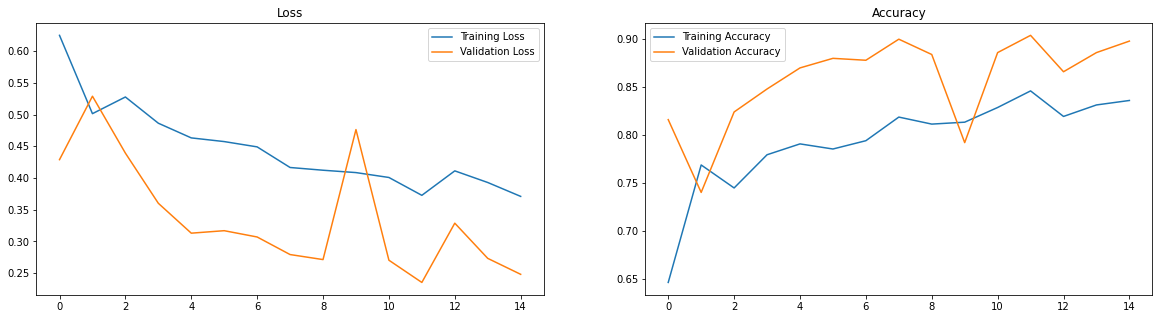

In [43]:
plot_loss_curves(history_8)